In [1]:
from era5plots import *

In [2]:
import matplotlib.pyplot as plt

In [8]:
def plot_period_difference_map(
    var_id: str,
    period_1: tuple[int, int] = (1960, 1989),
    period_2: tuple[int, int] = (1990, 2019),
    save: bool = False,
    figsize: tuple[int, int] = (12, 8),
    cmap: str = "RdBu_r",
    vmin: float = None,
    vmax: float = None,
    delta_units: str = None
):
    """
    Plot spatial difference map between two climatology periods.
    
    Args:
        var_id: Variable ID to plot
        period_1: First period (start_year, end_year)
        period_2: Second period (start_year, end_year)
        save: Whether to save the figure
        figsize: Figure size
        cmap: Colormap for the difference plot
        vmin: Minimum value for colorbar
        vmax: Maximum value for colorbar
        delta_units: Custom units for the difference label
    """
    # Load data
    fps = list_files_for_variable(var_id)
    ds = load_all_data_for_variable(fps)
    var = ds[var_id]
    ds_attrs = var.attrs
    
    # Compute period means
    def compute_period_mean(ds_subset, years):
        period = ds_subset.sel(time=slice(f"{years[0]}-01-01", f"{years[1]}-12-31"))
        return period.mean('time', keep_attrs=True)
    
    period1_mean = compute_period_mean(var, period_1)
    period2_mean = compute_period_mean(var, period_2)
    
    # Calculate difference
    delta = period2_mean - period1_mean
    
    # Get units and variable name
    unit = ds_attrs["units"]
    if unit == "degree_C":
        unit = "°C"
    var_name = ds_attrs.get("standard_name", var_id).replace("_", " ").title()
    desc = ds_attrs.get("long_name", var_id)
    
    # If delta units not specified, use the variable units
    if delta_units is None:
        delta_units = unit
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": ccrs.epsg(3338)})
    
    # Plot difference
    im = delta.plot(
        ax=ax,
        transform=ccrs.epsg(3338),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False,
        extend='both'
    )
    
    # Add colorbar
    cbar = plt.colorbar(
        im,
        ax=ax,
        orientation='horizontal',
        pad=0.05,
        shrink=0.8,
        label=f'Δ {var_name} ({delta_units})'
    )
    
    # Add map features
    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
    
    # Set title
    title = (
        f"ERA5 4km - {desc}\n"
        f"Difference: {period_2[0]}-{period_2[1]} vs {period_1[0]}-{period_1[1]}"
    )
    ax.set_title(title, fontsize=14, pad=10)
    
    plt.tight_layout()
    
    if save:
        fname = f"{var_id}_period_difference_{period_1[0]}-{period_1[1]}_vs_{period_2[0]}-{period_2[1]}.png"
        plt.savefig(f"figures/{fname}", dpi=144, bbox_inches='tight')
    
    plt.show()
    ds.close()

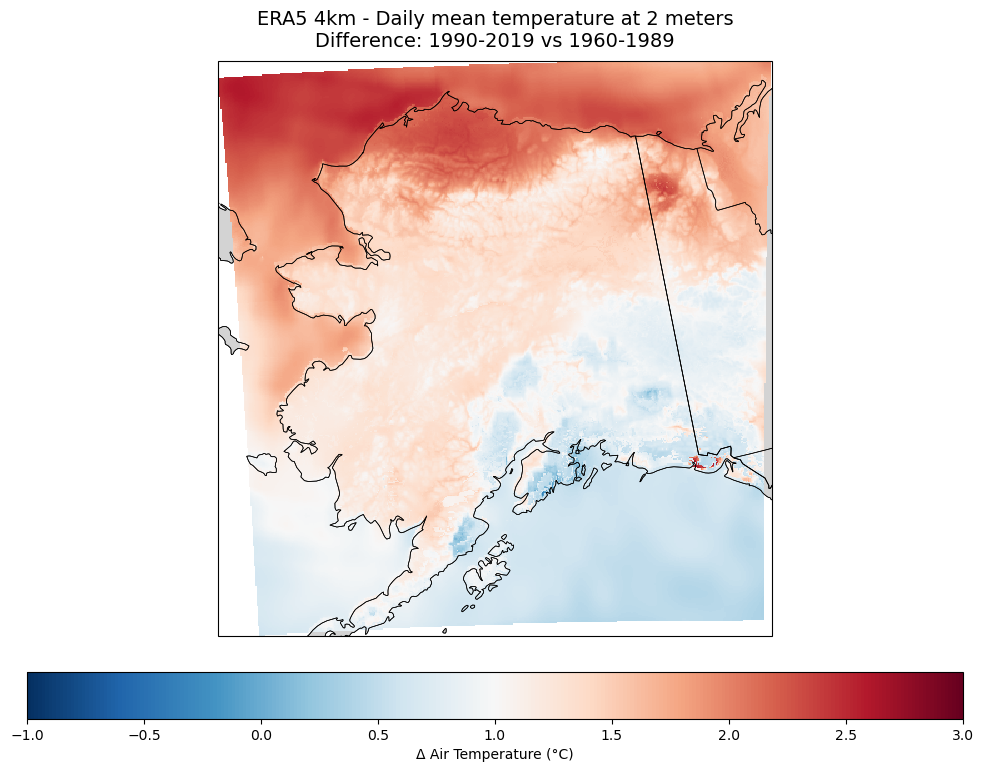

In [11]:
plot_period_difference_map(var_id="t2_mean", save=True, vmin=-1, vmax=3)

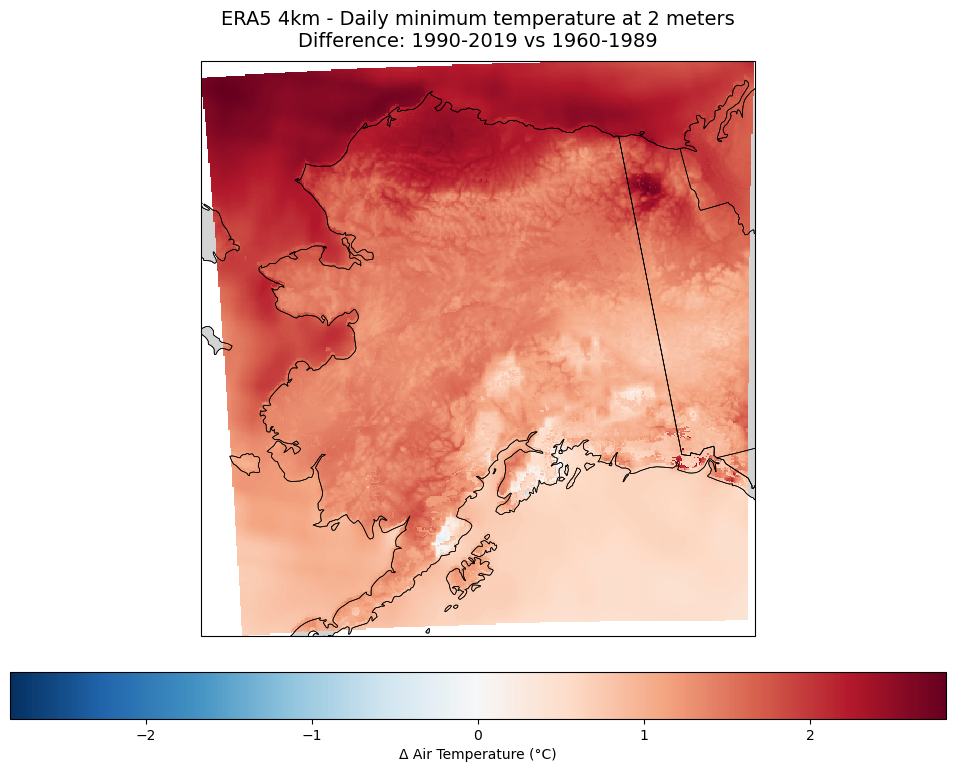

In [12]:
plot_period_difference_map(var_id="t2_min")

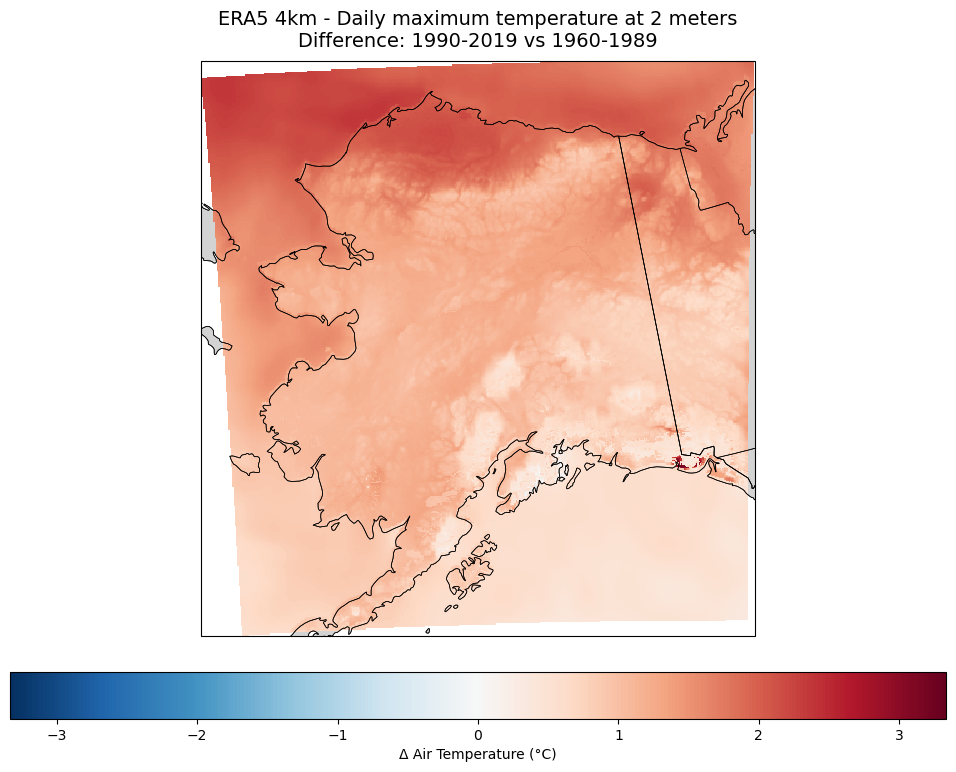

In [13]:
plot_period_difference_map(var_id="t2_max")